#### **Welcome to Assignment 2**
This assignment consists of three parts. Part-1 is based on the content you learned in Week-3 of course and Part-2 is based on the content you learned in Week-4 of the course. Part-3 is **un-graded** and mainly designed to help you flex the Deep Learning muscles grown in Part-2. 

Unlike the first two parts, you'll have to implement everything from scratch in Part-3. If you find answers to questions in Part-3, feel free to head out to the forums and discuss them with your classmates!

#### **Instructions**
1. Use Python 3.x to run this notebook
2. Write your code only in between the lines 'YOUR CODE STARTS HERE' and 'YOUR CODE ENDS HERE'.
you should not change anything else in the code cells, if you do, the answers you are supposed to get at the end of this assignment might be wrong.
3. Read documentation of each function carefully.
4. All the Best!

# Part-1

In [ ]:
# Imports
import numpy as np
import cv2
import matplotlib.pyplot as plt
from PIL import Image

# %matplotlib inline uncomment this line if you're running this notebook on your local PC

In [ ]:
# DO NOT CHANGE THIS CODE
np.random.seed(10)

### Question 1 : Line detection from a given image.


Find the starting and ending point co-ordinates of detected lines of a given image (line.png) using hough transform.

Following criterion need to be satisfied to qualify as a line:

(a) Minimum line length = 60;
(b) Maximum allowed gap between line segments = 250;
(c) Accumulator threshold parameter = 15  (only those lines are returned that get enough votes);
(d) Distance resolution of the accumulator in pixels = 1;
(e) Angle resolution of the accumulator in radians = pi/180



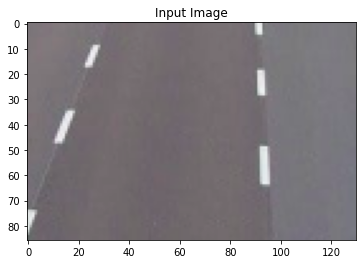

Line : 1. Starting co-ords: (0,83), Ending co-ords : (25,9)
Line : 2. Starting co-ords: (92,0), Ending co-ords : (95,64)
Line : 3. Starting co-ords: (1,81), Ending co-ords : (27,9)
Line : 4. Starting co-ords: (90,0), Ending co-ords : (92,63)


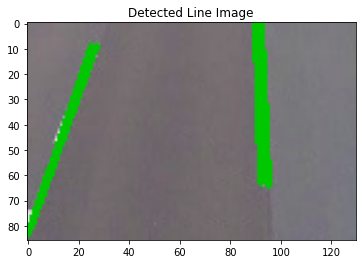

In [ ]:
#Read image 
img = cv2.imread('line.png', cv2.IMREAD_COLOR)

# Visualize the input image
plt.imshow(img)
plt.title('Input Image')
plt.show()

#### YOUR CODE STARTS HERE #####
#convert the image to gray-scale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
#### YOUR CODE ENDS HERE #####

#Find the edges in the image using canny detector

edges = cv2.Canny(gray, 50, 200)

#### YOUR CODE STARTS HERE #####

lines = cv2.HoughLinesP(edges, rho = 1,theta = np.pi/180,threshold = 15,minLineLength = 60,maxLineGap = 250)
#print(lines)
for i, co_ord in enumerate(lines):
    print(f"Line : {i+1}. Starting co-ords: ({co_ord[0][0]},{co_ord[0][1]}), Ending co-ords : ({co_ord[0][2]},{co_ord[0][3]})")
    cv2.line(img,(co_ord[0][0],co_ord[0][1]),(co_ord[0][2],co_ord[0][3]),(0,200,0),2)

#### YOUR CODE ENDS HERE #####
plt.imshow(img)
plt.title('Detected Line Image')
plt.show()

##Question 2: Point matching using RANSAC

Given two sets of points related by affine transformation(with an outlier rate), use the RANSAC method to estimate the Affine transformation parameters between them and the number of inliers(Matching points).

What is the estimated number of inliers for an outlier rate of 0.9?


In [ ]:
import numpy as np
np.random.seed(0)


# Affine Transformation
# |x'|  = |a, b| * |x|  +  |tx|
# |y'|    |c, d|   |y|     |ty|
# points_t =    A   * points_s  + t

# -------------------------------------------------------------

class Transform():

    def create_case(self, out_rate):
        ''' CREATE_CASE

            Method to generate a test case for affine transformation

            Input arguments:
            - out_rate : the percentage of outliers in test case

            Outputs:
            - points_s : Source points that will be transformed
            - points_t : warped points
            - A, t : parameters of affine transformation, A is a 2x2
            matrix, t is a 2x1 vector, both of them are created randomly

        '''


        # Generate an affine transformation
        # A is a 2x2 matrix, with values in range -2 to 2
        A = 4 * np.random.rand(2, 2) - 2

        # t is a 2x1 vector, with values in range -10 to 10
        t = 20 * np.random.rand(2, 1) - 10

        # Set the num_points = 1000 for the test case
        num_points = 1000

        #### YOUR CODE STARTS HERE ####
        # Compute the no. of outliers and the no. of inliers respectively
        outliers = int(num_points*out_rate)
        inliers = num_points - outliers
        #### YOUR CODE ENDS HERE ####

        # Gernerate source points, with scope from (0,0) to (100, 100)
        points_s = 100 * np.random.rand(2, num_points)

        # Initialization of the warped points matrix
        points_t = np.zeros((2, num_points))

        #### YOUR CODE STARTS HERE ####
        # Compute inliers in warped points matrix by applying A and t
        points_t[:, :inliers] = A@points_s[:,: inliers] + t
        #### YOUR CODE ENDS HERE ####

        # Outliers in warped points matrix
        points_t[:, inliers:] = 100 * np.random.rand(2, outliers)

        # Reset the order of warped points matrix
        # outliers and inliers will scatter randomly in test case
        rand_inx = np.random.permutation(num_points)
        points_s = points_s[:, rand_inx]
        points_t = points_t[:, rand_inx]

        return A, t, points_s, points_t

    def affine_transformation(self, points_s, points_t):  
        ''' AFFINE_TRANSFORMATION

            Perform affine transformation

            Input arguments:
            - points_t : points in target image
            - points_s : points in source image

            Outputs:

            - A, t : the affine transformation, A is a 2x2 matrix
            that indicates the rotation and scaling transformation,
            t is a 2x1 vector determines the translation

            Method:

            To estimate an affine transformation between two images,
            at least 3 corresponding points are needed.
            In this case, 6-parameter affine transformation are taken into
            consideration, which is shown as follows:

            | x' | = | a b | * | x | + | tx |
            | y' |   | c d |   | y |   | ty |

            For 3 corresponding points, 6 equations can be formed as below:

            | x1 y1 0  0  1 0 |       | a  |       | x1' |
            | 0  0  x1 y1 0 1 |       | b  |       | y1' |
            | x2 y2 0  0  1 0 |   *   | c  |   =   | x2' |
            | 0  0  x2 y2 0 1 |       | d  |       | y2' |
            | x3 y3 0  0  1 0 |       | tx |       | x3' |
            | 0  0  x3 y3 0 1 |       | ty |       | y3' |

            |------> M <------|   |-> theta <-|   |-> b <-|

            Solve the equation by calculating:  theta = M \ b
            Thus, affine transformation can be obtained as:

            A = | a b |     t = | tx |
                | c d |         | ty |

        '''

        #### YOUR CODE STARTS HERE ####

        M = np.zeros((6,6))
        b = np.zeros((6,1))
        theta = np.zeros((6,1))
        b = points_t[:,:3].reshape((6,1), order = 'F')
        for i in range(3):
          M[2*i,:] = [points_s[0][i], points_s[1][i], 0, 0, 1, 0]   
          M[2*i+1,:] = [ 0, 0, points_s[0][i], points_s[1][i], 0, 1] 
        
        #print(M.shape)
        theta = np.linalg.pinv(M).dot(b)
        A = theta[:4].reshape((2,2))
        t = theta[4:].reshape((2,1))

        return A,t


        #### YOUR CODE ENDS HERE ####
# -------------------------------------------------------------

# Create instance
tf = Transform()

# Generate a test case as validation with
# a rate of outliers
out_rate = 0.90
A_true, t_true, points_s, points_t = tf.create_case(out_rate)

# At least 3 corresponding points to
# estimate affine transformation
L = 3
# Randomly select 3 pairs of points to do estimation
idx = np.random.randint(0, points_s.shape[1], (L, 1))

A_test, t_test = tf.affine_transformation(points_s[:, idx], points_t[:, idx])

# -------------------------------------------------------------
# Test Class RansacClass
# The number of iterations in RANSAC
ITER_NUM = 2000


class RansacClass():

    def __init__(self, L=3, thr=1): 
        ''' __INIT__

            Initialize the instance.

            Input arguments:

            - L : the number of corresponding points,
            default is 3
            - thr : threshold that determines which points are inliers
            by comparing residual with it

        '''

        self.L = L
        self.thr = thr

    def calculate_distance(self, A, t, points_s, points_t):     
        ''' CALCULATE_DISTANCE

            Compute residual length between estimation and 
            real target points.
 

            Input arguments:

            - A, t : the estimated affine transformation
                     (using least square)
            - points_s : key points taken from source image
            - points_t : key points taken from target image

            Output: residual

            - residual : Euclidean distance between target 
            points and estimated points. Euclidean distance is
            nothing but the residual length

        '''

        ###YOUR CODE START HERE

        estimated_pts = A@points_s + t
        residual = np.sqrt(np.sum((estimated_pts-points_t)**2, axis = 0))

        return residual

        ###YOUR CODE ENDS HERE

    def apply_ransac(self, points_s, points_t):
        ''' APPLY_RANSAC

            Use this method to get the estimateda ffine 
            transformation, also inliers.

            Input arguments:

            - points_s : key points from source image
            - points_t : key points from target image

            Output:

            - A, t : estimated affine transformation
            - inliers : indices of inliers 

        '''
        #### YOUR CODE START HERE
        inlier_count = 0
        thr,L = self.thr, self.L
        A_rsc, t_rsc, inliers = None, None, None

        for i in range(ITER_NUM):
          idx = np.random.randint(0, points_s.shape[1], (L, 1))
          A_test, t_test = tf.affine_transformation(points_s[:, idx], points_t[:, idx])
          res = self.calculate_distance(A_test, t_test, points_s, points_t)
          #Calculating number of points with residual less than 'thr'
          bool_idx = res < thr  
          curr_count = np.sum(bool_idx)
          #If a better inlier count is observed, update the values
          if (inlier_count < curr_count): 
            inlier_count = curr_count
            A_rsc, t_rsc = A_test, t_test
            inliers = points_s[:, bool_idx]

        return A_rsc, t_rsc, inliers

        #### YOUR CODE ENDS HERE
# -------------------------------------------------------------

# Create instance
rs = RansacClass(L=3, thr=1)

residual = rs.calculate_distance(A_test, t_test, points_s, points_t)
A_rsc, t_rsc, inliers = rs.apply_ransac(points_s, points_t)

# print the number of inliners or point matches
print(inliers[0].shape)
print(f"Number of inliers = {inliers[0].shape[0]}")


(101,)
Number of inliers = 101


### Question 3: Detect corners in a given image using Harris Corner Detection Algorithm

Find the number of detected corner points in a given image (line.png) using Harris Corner Detection Algorithm. Note that, Following criterion MUST be satisfied while applying Harris Corner detection Algorithm:

(a)  The size of neighbourhood considered for corner detection = 2.
(b)  Aperture parameter of Sobel derivative used = 3.
(c)  Harris detector free parameter in the equation = 0.04.

How many corners are detected?



Number of detected corner points = 222


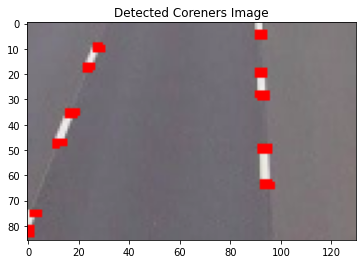

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import cv2

%matplotlib inline

# Read in the image
image = cv2.imread('line.png')

# Make a copy of the image
image_copy = np.copy(image)

# Change color to RGB (from BGR)
image_copy = cv2.cvtColor(image_copy, cv2.COLOR_BGR2RGB)

###YOUR CODE STARTS HERE

## STEP 1:  Convert to grayscale 
gray = cv2.cvtColor(image_copy, cv2.COLOR_RGB2GRAY)

## STEP 2: Detect corners 
gray = np.float32(gray)
dest = cv2.cornerHarris(gray,2,3,0.04)

## STEP 3: Dilate corner image to enhance corner points
dest = cv2.dilate(dest,None)

## STEP 4:set threshold value as 0.1 * (maximum value of dilated corner image obtained from STEP3)
threshold = 0.1*dest.max()

## STEP 5: Count numer of detected corner points and draw them on the image
idx_arr = dest > threshold #creating an indexing array
corner_count = np.sum(idx_arr)
print(f"Number of detected corner points = {corner_count}")
image_copy[idx_arr] = [255,0,0]
plt.imshow(image_copy)
plt.title('Detected Coreners Image')
plt.show()


### YOUR CODE ENDS HERE

# Part-2

In this section, we will train a neural network to learn to identify numerals from [MNIST](http://yann.lecun.com/exdb/mnist/) dataset. Fill out the missing pieces in each of the following cells. 

In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
import torch.nn.functional as F
import timeit
import unittest

## Please DONOT remove these lines. 
torch.manual_seed(0)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(0)

### Data Loading and Pre-processing

In [ ]:
# check availability of GPU and set the device accordingly
#### YOUR CODE STARTS HERE ####
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# define a transforms for preparing the dataset
transform = transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.1307), (0.3081))])
         # convert the image to a pytorch tensor
        # normalise the images with mean (0.1307) and std (0.3081) of the dataset
#### YOUR CODE ENDS HERE ####

In [ ]:
# Load the MNIST training, test datasets using `torchvision.datasets.MNIST` using the transform defined above
#### YOUR CODE STARTS HERE ####
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)
#### YOUR CODE ENDS HERE ####

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw
Processing...
Done!


/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:480: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [ ]:
# create dataloaders for training and test datasets
# use a batch size of 32 and set shuffle=True for the training set
#### YOUR CODE STARTS HERE ####
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=32,shuffle=True, num_workers=2)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=32,shuffle=False, num_workers=2)
#### YOUR CODE ENDS HERE ####

### Network Definition

In [ ]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        #### YOUR CODE STARTS HERE ####
        # define a conv layer with output channels as 16, kernel size of 3 and stride of 1
        self.conv1 = nn.Conv2d(1, 16, kernel_size = 3, stride = 1)
        # define a conv layer with output channels as 32, kernel size of 3 and stride of 1
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride = 1)
        # define a conv layer with output channels as 64, kernel size of 3 and stride of 1
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, stride = 1)
        # define a max pooling layer with kernel size 2
        self.maxpool = nn.MaxPool2d(2, stride=2)
        # define dropout layer with a probability of 0.25
        self.Dropout1 = nn.Dropout(p = 0.25)
        # define dropout layer with a probability of 0.5
        self.Dropout2 = nn.Dropout(p = 0.5)
        # define a linear(dense) layer with 128 output features
        self.fc1 = nn.Linear(64 * 11 * 11, 128)
        # define a linear(dense) layer with output features corresponding to the number of classes in the dataset
        self.fc2 = nn.Linear(128,10)
        #### YOUR CODE ENDS HERE ####

    def forward(self, x):
        # Use the layers defined above in a sequential way (folow the same as the layer definitions above) and 
        # write the forward pass, after each of conv1, conv2, conv3 and fc1 use a relu activation. 
        # use the first dropout after maxpool and the other one before you final FC layer
        #### YOUR CODE STARTS HERE ####
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = self.maxpool(x)
        x = self.Dropout1(x)
        x = x.view(-1, 64*11*11)
        x = F.relu(self.fc1(x))
        x = self.Dropout2(x)
        out = self.fc2(x)

        #### YOUR CODE ENDS HERE ####
        output = F.log_softmax(out, dim=1)
        return output

### Sanity Check
Make sure all the tests below pass without any errors, before you proceed with the training part.

In [ ]:
import unittest

class TestImplementations(unittest.TestCase):
    
    # Dataloading tests
    def test_dataset(self):
        self.dataset_classes = ['0 - zero',
                                '1 - one',
                                '2 - two',
                                '3 - three',
                                '4 - four',
                                '5 - five',
                                '6 - six',
                                '7 - seven',
                                '8 - eight',
                                '9 - nine']
        self.assertTrue(train_dataset.classes == self.dataset_classes)
        self.assertTrue(train_dataset.train == True)
    
    def test_dataloader(self):        
        self.assertTrue(train_dataloader.batch_size == 32)
        self.assertTrue(test_dataloader.batch_size == 32)      
         
    def test_total_parameters(self):
        model = Net().to(device)
        self.assertTrue(sum(p.numel() for p in model.parameters()) == 1015946)

suite = unittest.TestLoader().loadTestsFromModule(TestImplementations())
unittest.TextTestRunner().run(suite)

...
----------------------------------------------------------------------
Ran 3 tests in 0.019s

OK


<unittest.runner.TextTestResult run=3 errors=0 failures=0>

### Training and Inference

In [ ]:
def train(model, device, train_loader, optimizer, epoch):
    model.train()
    epoch_loss = []  ##for plotting
    for batch_idx, (data, target) in enumerate(train_loader):
      #### YOUR CODE STARTS HERE ####
        # send the image, target to the device
        data = data.to(device)
        target = target.to(device)
        # flush out the gradients stored in optimizer
        optimizer.zero_grad()
        # pass the image to the model and assign the output to variable named output
        output = model(data)
        # calculate the loss (use nll_loss in pytorch)
        loss = F.nll_loss(output,target)
        # do a backward pass
        loss.backward()
        epoch_loss.append(loss.item()) ##for plotting
        # update the weights
        optimizer.step()

      #### YOUR CODE ENDS HERE ####
        if batch_idx % 20 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
    
    return sum(epoch_loss)/len(epoch_loss) ##for plotting purposes

In [ ]:
def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
          ### YOUR CODE STARTS HERE ####
            # send the image, target to the device
            data = data.to(device)
            target = target.to(device)
            # pass the image to the model and assign the output to variable named output
            output = model(data)
            test_loss += F.nll_loss(output,target)# sum up batch loss
          #### YOUR CODE ENDS HERE ####
            # get the index of the max log-probability
            _, pred = torch.max(output.data, 1)
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    print('Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

### Question 4

Use Adam as the optimiser and train the model for 25 epochs. Report the train, test loss and accuracies along with the total time taken for training. (Use plots if required)

In [ ]:
###--- TRAINING ---###
import time
import matplotlib.pyplot as plt
model = Net()
if torch.cuda.is_available():
    model.cuda()
optimizer = optim.Adam(model.parameters())

loss_vals = []
##Training for 25 epochs:
start = time.time()
for i in range(25):
  loss = train(model, device, train_dataloader, optimizer, i+1)
  loss_vals.append(loss)
end = time.time()

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.309116
Train Epoch: 1 [640/60000 (1%)]	Loss: 0.983487
Train Epoch: 1 [1280/60000 (2%)]	Loss: 0.804610
Train Epoch: 1 [1920/60000 (3%)]	Loss: 0.343898
Train Epoch: 1 [2560/60000 (4%)]	Loss: 0.486832
Train Epoch: 1 [3200/60000 (5%)]	Loss: 0.483999
Train Epoch: 1 [3840/60000 (6%)]	Loss: 0.307923
Train Epoch: 1 [4480/60000 (7%)]	Loss: 0.500143
Train Epoch: 1 [5120/60000 (9%)]	Loss: 0.200927
Train Epoch: 1 [5760/60000 (10%)]	Loss: 0.257890
Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.199652
Train Epoch: 1 [7040/60000 (12%)]	Loss: 0.754700
Train Epoch: 1 [7680/60000 (13%)]	Loss: 0.406293
Train Epoch: 1 [8320/60000 (14%)]	Loss: 0.140584
Train Epoch: 1 [8960/60000 (15%)]	Loss: 0.252655
Train Epoch: 1 [9600/60000 (16%)]	Loss: 0.260048
Train Epoch: 1 [10240/60000 (17%)]	Loss: 0.099505
Train Epoch: 1 [10880/60000 (18%)]	Loss: 0.102352
Train Epoch: 1 [11520/60000 (19%)]	Loss: 0.150189
Train Epoch: 1 [12160/60000 (20%)]	Loss: 0.131199
Train Epoch: 1 [12800/60000 (

Total time taken to train = 7min 29s



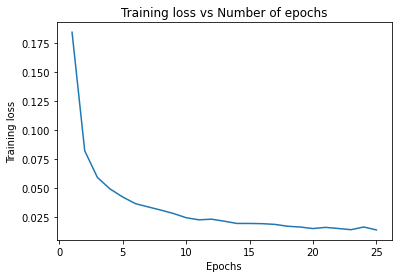

In [ ]:
###--- TIME TAKEN and PLOT ---###
print(f"Total time taken to train = {int(end - start)//60}min {int(end - start)%60}s\n")
plt.plot(np.linspace(1, 25, 25).astype(int), loss_vals)
plt.xlabel('Epochs')
plt.ylabel('Training loss')
plt.title("Training loss vs Number of epochs");

In [ ]:
### ---TEST and TRAIN accuracies--- ###
print("TRAIN SET:")
test(model, device, train_dataloader)
print("TEST SET:")
test(model, device, test_dataloader)

TRAIN SET:
Average loss: 0.0000, Accuracy: 59977/60000 (100%)

TEST SET:
Average loss: 0.0009, Accuracy: 9937/10000 (99%)



### Question 5

Modify the network defined in the previous step to replace ReLU activations with Sigmoid and report the final test accuracy. Is there a drop in accuracy, what do you think is the reason? 

In [ ]:
class Net_sig(nn.Module):
    def __init__(self):
        super(Net_sig, self).__init__()
        #### YOUR CODE STARTS HERE ####
        # define a conv layer with output channels as 16, kernel size of 3 and stride of 1
        self.conv1 = nn.Conv2d(1, 16, kernel_size = 3, stride = 1)
        # define a conv layer with output channels as 32, kernel size of 3 and stride of 1
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride = 1)
        # define a conv layer with output channels as 64, kernel size of 3 and stride of 1
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, stride = 1)
        # define a max pooling layer with kernel size 2
        self.maxpool = nn.MaxPool2d(2, stride=2)
        # define dropout layer with a probability of 0.25
        self.Dropout1 = nn.Dropout(p = 0.25)
        # define dropout layer with a probability of 0.5
        self.Dropout2 = nn.Dropout(p = 0.5)
        # define a linear(dense) layer with 128 output features
        self.fc1 = nn.Linear(64 * 11 * 11, 128)
        # define a linear(dense) layer with output features corresponding to the number of classes in the dataset
        self.fc2 = nn.Linear(128,10)
        #### YOUR CODE ENDS HERE ####

    def forward(self, x):
        #Using sigmoid activations instead ReLU
        #### YOUR CODE STARTS HERE ####
        x = torch.sigmoid(self.conv1(x)) 
        x = torch.sigmoid(self.conv2(x))
        x = torch.sigmoid(self.conv3(x)) 
        x = self.maxpool(x)
        x = self.Dropout1(x)
        x = x.view(-1, 64*11*11)
        x = torch.sigmoid(self.fc1(x)) 
        x = self.Dropout2(x)
        out = self.fc2(x)
        #### YOUR CODE ENDS HERE ####
        output = F.log_softmax(out, dim=1)
        return output

### ---TRAINING ---###
model_sig = Net_sig()
if torch.cuda.is_available():
    model_sig.cuda()
optimizer = optim.Adam(model_sig.parameters())

##Training for 25 epochs:
for i in range(25):
  train(model_sig, device, train_dataloader, optimizer, i+1)


Train Epoch: 1 [0/60000 (0%)]	Loss: 2.272089
Train Epoch: 1 [640/60000 (1%)]	Loss: 2.252157
Train Epoch: 1 [1280/60000 (2%)]	Loss: 2.394516
Train Epoch: 1 [1920/60000 (3%)]	Loss: 2.343135
Train Epoch: 1 [2560/60000 (4%)]	Loss: 2.259943
Train Epoch: 1 [3200/60000 (5%)]	Loss: 2.268572
Train Epoch: 1 [3840/60000 (6%)]	Loss: 2.379642
Train Epoch: 1 [4480/60000 (7%)]	Loss: 2.376674
Train Epoch: 1 [5120/60000 (9%)]	Loss: 2.327438
Train Epoch: 1 [5760/60000 (10%)]	Loss: 2.300930
Train Epoch: 1 [6400/60000 (11%)]	Loss: 2.254185
Train Epoch: 1 [7040/60000 (12%)]	Loss: 2.187783
Train Epoch: 1 [7680/60000 (13%)]	Loss: 1.857789
Train Epoch: 1 [8320/60000 (14%)]	Loss: 1.660151
Train Epoch: 1 [8960/60000 (15%)]	Loss: 1.421715
Train Epoch: 1 [9600/60000 (16%)]	Loss: 1.159143
Train Epoch: 1 [10240/60000 (17%)]	Loss: 1.024186
Train Epoch: 1 [10880/60000 (18%)]	Loss: 1.058496
Train Epoch: 1 [11520/60000 (19%)]	Loss: 1.217364
Train Epoch: 1 [12160/60000 (20%)]	Loss: 0.874127
Train Epoch: 1 [12800/60000 (

In [ ]:
###---Test set accuracy---###
print("TEST SET:")
test(model_sig, device, test_dataloader)

TEST SET:
Average loss: 0.0010, Accuracy: 9907/10000 (99%)



#### Answer 5

Initially I trained both type of networks (ReLU vs sigmoid) for 1 epoch. A noticable difference in accuracy was observed (ReLU: 99% vs Sigmoid: 94%). The reduced accuracy when using sigmoid activations is because of 'vanishing gardients' problem. For majority of input values, the sigmoid gradient -> 0. Moreover, when these gradients are continously multiplied during backprop, they almost completely diminish. Thus as the gradients of weights -> 0, the model learns very slowly (especially the initial layers) or can even stop learning after a point.

**BUT**, having said this, in this network, after training using different activations (ReLU, sigmoid) for 25 epochs, both give almost same accuracies (99%). The network with ReLU activation does slightly better (30 more examples are classified correctly).

### Question 6

Train the network defined in Question-1 with a different optimiser other than Adam, do you see any difference in performance? Substantiate your observations with relevant explanations.

In [ ]:
# Note: Same network definition as in Question-4 is used.

###--- TRAINING ---###
##Training with SGD+nesterov momentum.
model_sgd = Net()
if torch.cuda.is_available():
    model_sgd.cuda()
optimizer = optim.SGD(model_sgd.parameters(), lr = 0.001, momentum=0.9, nesterov=True)

##Training for 25 epochs:
for i in range(25):
  train(model_sgd, device, train_dataloader, optimizer, i+1)


Train Epoch: 1 [0/60000 (0%)]	Loss: 2.286044
Train Epoch: 1 [640/60000 (1%)]	Loss: 2.295509
Train Epoch: 1 [1280/60000 (2%)]	Loss: 2.302834
Train Epoch: 1 [1920/60000 (3%)]	Loss: 2.268798
Train Epoch: 1 [2560/60000 (4%)]	Loss: 2.212365
Train Epoch: 1 [3200/60000 (5%)]	Loss: 2.159656
Train Epoch: 1 [3840/60000 (6%)]	Loss: 1.797610
Train Epoch: 1 [4480/60000 (7%)]	Loss: 1.251281
Train Epoch: 1 [5120/60000 (9%)]	Loss: 0.849902
Train Epoch: 1 [5760/60000 (10%)]	Loss: 1.284284
Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.484067
Train Epoch: 1 [7040/60000 (12%)]	Loss: 1.219497
Train Epoch: 1 [7680/60000 (13%)]	Loss: 0.549352
Train Epoch: 1 [8320/60000 (14%)]	Loss: 0.495364
Train Epoch: 1 [8960/60000 (15%)]	Loss: 0.873900
Train Epoch: 1 [9600/60000 (16%)]	Loss: 0.557388
Train Epoch: 1 [10240/60000 (17%)]	Loss: 0.813439
Train Epoch: 1 [10880/60000 (18%)]	Loss: 0.803605
Train Epoch: 1 [11520/60000 (19%)]	Loss: 0.599203
Train Epoch: 1 [12160/60000 (20%)]	Loss: 0.832407
Train Epoch: 1 [12800/60000 (

In [ ]:
### ---Test set accuracy--- ###
print("TEST SET:")
test(model_sgd, device, test_dataloader)

TEST SET:
Average loss: 0.0009, Accuracy: 9908/10000 (99%)



#### Answer 6
I first trained the model with only SGD (for 10 epochs). The training time took relatively longer (compared to Adam),and the final accuracy reported was 96% (vs Adam: 99%). Finally, used SGD with nesterov momentum. Training time reduced slightly, but more importantly 99% accuracy was achieved (same as Adam).

**Conclusion:** For this network, SGD+nesetrov momentum gives same perfomance as Adam.

**Explanation:** Using only SGD is usually very noisy, and the gradients osscilate a lot in plateau regions (low curvature) of the loss surface. With momentum we try taking larger gradient steps in flat regions,hence osscilations are reduced. Better than this is 'nesetrov' momentum, which uses 'look ahead gradient' to make it's final update. This further reduces the osscilations. With these modifications, perfomance on par with Adam optimizer is achieved.


### Question 7

Initialize the `Conv2d` layers in the network defined in Question-1 `(Net)` with all ones (both weights and bias). Train the network with Adam optimizer and report the final test accuracy. Is there any difference in the performance? If yes, what do you think is the reason? 

In [ ]:
class Net_ones(nn.Module):
    def __init__(self):
        super(Net_ones, self).__init__()
        #### YOUR CODE STARTS HERE ####
        # define a conv layer with output channels as 16, kernel size of 3 and stride of 1
        self.conv1 = nn.Conv2d(1, 16, kernel_size = 3, stride = 1)
        nn.init.ones_(self.conv1.weight)
        nn.init.ones_(self.conv1.bias)  
        # define a conv layer with output channels as 32, kernel size of 3 and stride of 1
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride = 1)
        nn.init.ones_(self.conv2.weight)
        nn.init.ones_(self.conv2.bias)  
        # define a conv layer with output channels as 64, kernel size of 3 and stride of 1
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, stride = 1)
        nn.init.ones_(self.conv3.weight) 
        nn.init.ones_(self.conv3.bias)   
        # define a max pooling layer with kernel size 2
        self.maxpool = nn.MaxPool2d(2, stride=2)
        # define dropout layer with a probability of 0.25
        self.Dropout1 = nn.Dropout(p = 0.25)
        # define dropout layer with a probability of 0.5
        self.Dropout2 = nn.Dropout(p = 0.5)
        # define a linear(dense) layer with 128 output features
        self.fc1 = nn.Linear(64 * 11 * 11, 128)
        # define a linear(dense) layer with output features corresponding to the number of classes in the dataset
        self.fc2 = nn.Linear(128,10)
        #### YOUR CODE ENDS HERE ####

    def forward(self, x):

        #### YOUR CODE STARTS HERE ####
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = self.maxpool(x)
        x = self.Dropout1(x)
        x = x.view(-1, 64*11*11)
        x = F.relu(self.fc1(x))
        x = self.Dropout2(x)
        out = self.fc2(x)
        #### YOUR CODE ENDS HERE ####

        output = F.log_softmax(out, dim=1)
        return output
        
### ---TRAINING--- ###
model_ones = Net_ones()
if torch.cuda.is_available():
    model_ones.cuda()
optimizer = optim.Adam(model_ones.parameters())

##Training for 25 epochs:
for i in range(25):
  train(model_ones, device, train_dataloader, optimizer, i+1)


Train Epoch: 1 [0/60000 (0%)]	Loss: 188524.421875
Train Epoch: 1 [640/60000 (1%)]	Loss: 2.216200
Train Epoch: 1 [1280/60000 (2%)]	Loss: 2.233577
Train Epoch: 1 [1920/60000 (3%)]	Loss: 2.310633
Train Epoch: 1 [2560/60000 (4%)]	Loss: 2.304194
Train Epoch: 1 [3200/60000 (5%)]	Loss: 2.300539
Train Epoch: 1 [3840/60000 (6%)]	Loss: 2.308310
Train Epoch: 1 [4480/60000 (7%)]	Loss: 2.291832
Train Epoch: 1 [5120/60000 (9%)]	Loss: 2.317528
Train Epoch: 1 [5760/60000 (10%)]	Loss: 2.301802
Train Epoch: 1 [6400/60000 (11%)]	Loss: 2.317921
Train Epoch: 1 [7040/60000 (12%)]	Loss: 2.304351
Train Epoch: 1 [7680/60000 (13%)]	Loss: 2.307025
Train Epoch: 1 [8320/60000 (14%)]	Loss: 2.306007
Train Epoch: 1 [8960/60000 (15%)]	Loss: 2.293619
Train Epoch: 1 [9600/60000 (16%)]	Loss: 2.283789
Train Epoch: 1 [10240/60000 (17%)]	Loss: 2.303400
Train Epoch: 1 [10880/60000 (18%)]	Loss: 2.315946
Train Epoch: 1 [11520/60000 (19%)]	Loss: 2.303982
Train Epoch: 1 [12160/60000 (20%)]	Loss: 2.305850
Train Epoch: 1 [12800/60

In [ ]:
### ---Test Set accuracy--- ###
print("TEST SET:")
test(model_ones, device, test_dataloader)

TEST SET:
Average loss: 0.0720, Accuracy: 1135/10000 (11%)



#### Answer 7

Thers is a drastic drop in performance observed. After training the network for 25 epochs we observe only 11% test accuracy.

**Reason:** Since all the weights and biases of conv layers are initialized to one, the network fails to learn properly. Due to symmetrical weights, whatever be the input the hidden unit outputs will be identical. This means that all hidden unit contribute to final loss in an identical manner, implying gardients will also be similar. Finally the learnt weights will also be identical. This is undesirable as the model is not able to learn the right functions to make correct predictions.
As observed, the final test accuracy is very low, only 11%.

### Question 8

Initialize the network defined in Question-1 `(Net)` with Xavier's initialization ([torch.nn.init.xavier_normal](https://pytorch.org/docs/stable/nn.init.html))(for bias use zero). Train the network with Adam optimizer and report the final test accuracy.

In [ ]:
class Net_xav(nn.Module):
    def __init__(self):
        super(Net_xav, self).__init__()
        #### YOUR CODE STARTS HERE ####
        # define a conv layer with output channels as 16, kernel size of 3 and stride of 1
        self.conv1 = nn.Conv2d(1, 16, kernel_size = 3, stride = 1)
        nn.init.xavier_normal_(self.conv1.weight)
        nn.init.zeros_(self.conv1.bias)          
        # define a conv layer with output channels as 32, kernel size of 3 and stride of 1
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride = 1)
        nn.init.xavier_normal_(self.conv2.weight)
        nn.init.zeros_(self.conv2.bias)          
        # define a conv layer with output channels as 64, kernel size of 3 and stride of 1
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, stride = 1)
        nn.init.xavier_normal_(self.conv3.weight)
        nn.init.zeros_(self.conv3.bias)          
        # define a max pooling layer with kernel size 2
        self.maxpool = nn.MaxPool2d(2, stride=2)
        # define dropout layer with a probability of 0.25
        self.Dropout1 = nn.Dropout(p = 0.25)
        # define dropout layer with a probability of 0.5
        self.Dropout2 = nn.Dropout(p = 0.5)
        # define a linear(dense) layer with 128 output features
        self.fc1 = nn.Linear(64 * 11 * 11, 128)
        nn.init.xavier_normal_(self.fc1.weight) 
        nn.init.zeros_(self.fc1.bias)           
        # define a linear(dense) layer with output features corresponding to the number of classes in the dataset
        self.fc2 = nn.Linear(128,10)
        nn.init.xavier_normal_(self.fc2.weight) 
        nn.init.zeros_(self.fc2.bias)           
        #### YOUR CODE ENDS HERE ####

    def forward(self, x):
        #### YOUR CODE STARTS HERE ####
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = self.maxpool(x)
        x = self.Dropout1(x)
        x = x.view(-1, 64*11*11)
        x = F.relu(self.fc1(x))
        x = self.Dropout2(x)
        out = self.fc2(x)
        #### YOUR CODE ENDS HERE ####

        output = F.log_softmax(out, dim=1)
        return output
###--- TRAINING ---###
model_xav = Net()
if torch.cuda.is_available():
    model_xav.cuda()
optimizer = optim.Adam(model_xav.parameters())

##Training for 25 epochs:
for i in range(25):
  train(model_xav, device, train_dataloader, optimizer, i+1)


Train Epoch: 1 [0/60000 (0%)]	Loss: 2.303562
Train Epoch: 1 [640/60000 (1%)]	Loss: 0.911886
Train Epoch: 1 [1280/60000 (2%)]	Loss: 0.427255
Train Epoch: 1 [1920/60000 (3%)]	Loss: 0.943237
Train Epoch: 1 [2560/60000 (4%)]	Loss: 0.576778
Train Epoch: 1 [3200/60000 (5%)]	Loss: 0.371820
Train Epoch: 1 [3840/60000 (6%)]	Loss: 0.169414
Train Epoch: 1 [4480/60000 (7%)]	Loss: 0.288542
Train Epoch: 1 [5120/60000 (9%)]	Loss: 0.353838
Train Epoch: 1 [5760/60000 (10%)]	Loss: 0.301463
Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.162874
Train Epoch: 1 [7040/60000 (12%)]	Loss: 0.513258
Train Epoch: 1 [7680/60000 (13%)]	Loss: 0.311851
Train Epoch: 1 [8320/60000 (14%)]	Loss: 0.347476
Train Epoch: 1 [8960/60000 (15%)]	Loss: 0.358129
Train Epoch: 1 [9600/60000 (16%)]	Loss: 0.143448
Train Epoch: 1 [10240/60000 (17%)]	Loss: 0.268162
Train Epoch: 1 [10880/60000 (18%)]	Loss: 0.199307
Train Epoch: 1 [11520/60000 (19%)]	Loss: 0.096258
Train Epoch: 1 [12160/60000 (20%)]	Loss: 0.333043
Train Epoch: 1 [12800/60000 (

In [ ]:
### ---Test Set accuracy--- ###
print("TEST SET:")
test(model_xav, device, test_dataloader)

TEST SET:
Average loss: 0.0011, Accuracy: 9928/10000 (99%)



### Question 9

Add three batch-norm layers to the network defined in `Question-1` and report the final test accuracy. How does batch-norm help? 

In [ ]:
class Net_bn(nn.Module):
    def __init__(self):
        super(Net_bn, self).__init__()
        #### YOUR CODE STARTS HERE ####
        # define a conv layer with output channels as 16, kernel size of 3 and stride of 1
        self.conv1 = nn.Conv2d(1, 16, kernel_size = 3, stride = 1)
        self.bn1 = nn.BatchNorm2d(16)  
        # define a conv layer with output channels as 32, kernel size of 3 and stride of 1
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride = 1)
        self.bn2 = nn.BatchNorm2d(32)  
        # define a conv layer with output channels as 64, kernel size of 3 and stride of 1
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, stride = 1)
        self.bn3 = nn.BatchNorm2d(64)  
        # define a max pooling layer with kernel size 2
        self.maxpool = nn.MaxPool2d(2, stride=2)
        # define dropout layer with a probability of 0.25
        self.Dropout1 = nn.Dropout(p = 0.25)
        # define dropout layer with a probability of 0.5
        self.Dropout2 = nn.Dropout(p = 0.5)
        # define a linear(dense) layer with 128 output features
        self.fc1 = nn.Linear(64 * 11 * 11, 128)
        # define a linear(dense) layer with output features corresponding to the number of classes in the dataset
        self.fc2 = nn.Linear(128,10)
        #### YOUR CODE ENDS HERE ####

    def forward(self, x):
        # Using BN layers after each convolution, before ReLU activation. 
        #### YOUR CODE STARTS HERE ####
        x = F.relu(self.bn1(self.conv1(x))) 
        x = F.relu(self.bn2(self.conv2(x))) 
        x = F.relu(self.bn3(self.conv3(x))) 
        x = self.maxpool(x)
        x = self.Dropout1(x)
        x = x.view(-1, 64*11*11)
        x = F.relu(self.fc1(x))
        x = self.Dropout2(x)
        out = self.fc2(x)

        #### YOUR CODE ENDS HERE ####
        output = F.log_softmax(out, dim=1)
        return output

### ---TRAINING ---###
model_bn = Net_bn()
if torch.cuda.is_available():
    model_bn.cuda()
optimizer = optim.Adam(model_bn.parameters())

##Training for 25 epochs:
for i in range(25):
  train(model_bn, device, train_dataloader, optimizer, i+1)
  

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.420473
Train Epoch: 1 [640/60000 (1%)]	Loss: 0.968521
Train Epoch: 1 [1280/60000 (2%)]	Loss: 0.660670
Train Epoch: 1 [1920/60000 (3%)]	Loss: 0.537457
Train Epoch: 1 [2560/60000 (4%)]	Loss: 0.753230
Train Epoch: 1 [3200/60000 (5%)]	Loss: 0.460628
Train Epoch: 1 [3840/60000 (6%)]	Loss: 0.244364
Train Epoch: 1 [4480/60000 (7%)]	Loss: 0.592980
Train Epoch: 1 [5120/60000 (9%)]	Loss: 0.349009
Train Epoch: 1 [5760/60000 (10%)]	Loss: 0.560689
Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.457561
Train Epoch: 1 [7040/60000 (12%)]	Loss: 0.588185
Train Epoch: 1 [7680/60000 (13%)]	Loss: 0.100645
Train Epoch: 1 [8320/60000 (14%)]	Loss: 0.073174
Train Epoch: 1 [8960/60000 (15%)]	Loss: 0.193400
Train Epoch: 1 [9600/60000 (16%)]	Loss: 0.326250
Train Epoch: 1 [10240/60000 (17%)]	Loss: 0.301100
Train Epoch: 1 [10880/60000 (18%)]	Loss: 0.091274
Train Epoch: 1 [11520/60000 (19%)]	Loss: 0.257142
Train Epoch: 1 [12160/60000 (20%)]	Loss: 0.319312
Train Epoch: 1 [12800/60000 (

In [ ]:
###---Test set accuracy---###
print("TEST SET:")
test(model_bn, device, test_dataloader)

TEST SET:
Average loss: 0.0010, Accuracy: 9937/10000 (99%)



#### Answer 9

Batch norm helps tackle the 'internal covariate shift' problem in neural nets. Just as how we normalize our input data, batch norm explicitly ensures that the input to all the consequent layers are also normalized (i.e standard normal distribution). Further, it also introduces learnable params $\gamma$ (scale param) and $\beta$ (shift param), so the network can learn it's own suitable distribution (not necessarily standard normal).

Batch norm helps solve the vanshing/exploding gardient problems, and hence is less sensitive to weight initialization, learning rate settings. Batch norm also has a regularizing effect.



# Part-3 (Optional)

This section is un-graded and purely for practice. 

Main focus of this part is to help you flex the deep learning muscles built in the above part. You should build a network on the [SVHN dataset](http://ufldl.stanford.edu/housenumbers/). This dataset is similar to MNIST but unlike MNIST, the images are colored and more complex. 

As of writing this, the state-of-the-art(SoTA) performance on this dataset is 98.98%. You can try to start with the simple network we defined above for the MNSIT dataset(with some modification for dealing with different sized colored images unlike MNIST). But to achive the SoTA performance you need to do a lot of hackery. These are list of few things, we would encourage you to try: 

- Use data augmentation wisely. Read and understand how to perform the augmentations listed below. 
    * RandomFlips, Color Jittering
    * Cutout, Cutmix
    * Mixup
    * Auto-augment

- Try to increase the image size using standard image interpolation techniques. Try using tricks like Progressive resizing of images and see if it helps. 

- After certain number of layers, adding more layer might not be of much help, run experiments on SVHN and see if you observe this. 

- To understand the difficulties in training deeper networks read this paper: [Deep Residual Learning for Image Recognition](https://arxiv.org/abs/1512.03385)

- To improve the performance on SVHN, try using architectures like [ResNet](https://arxiv.org/abs/1512.03385), [DesnseNet](https://arxiv.org/abs/1608.06993) or [EfficientNet](https://arxiv.org/abs/1905.11946). Most of these architectures are available by default in PyTorch.
